In [1]:
from pathlib import Path
import math
from itertools import combinations_with_replacement, islice

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors
import matplotlib.cm
from tqdm.auto import tqdm

import numpy as np
import numpy

import torch
import torch.nn as nn

# load up MNIST

In [2]:
BINS = 16
MNIST_LAYERS = [(25, 6), (6, 6), (6, 6), (6, 5)]
ACTIVATION = nn.Sigmoid()
RUNS = 3
FREQUENCY = 5 # epochs per measurement
EPOCHS = 500
BATCH_SIZE = 50

top_str = ""
for i, l in enumerate(MNIST_LAYERS):
    if i == len(MNIST_LAYERS)-1:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-{out_w}"
    else:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-"

In [3]:
exp_dir = Path('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-5_8bins_fixedlonger')
run_folders = [exp_dir / f"run{i}-frames" for i in range(1, RUNS+1)]
# run_folders = [here / "run1-frames"]
runs_frames = [list(run.glob('*.frame')) for run in run_folders]
print(run_folders)

[PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-5_8bins_fixedlonger/run1-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-5_8bins_fixedlonger/run2-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-5_8bins_fixedlonger/run3-frames')]


In [4]:
all(d.exists() for d in run_folders)

True

In [5]:
def get_measures(path_to_frame):
    frame = torch.load(path_to_frame)
    measure_names = [
        'batches',
        'epochs',
        'training_loss',
        'testing_loss',
        'training_accuracy',
        'testing_accuracy',
        'model'
    ]
    for (start_i, end_i) in combinations_with_replacement(range(len(MNIST_LAYERS)), 2):
        measure_names.append(f"pairwise-ei:{start_i}-{end_i}")
        measure_names.append(f"pairwise-sensitivity:{start_i}-{end_i}")
        measure_names.append(f"vector-ei:{start_i}-{end_i}")
    measures = {}
    for name in measure_names:
        if type(frame[name]) is torch.Tensor:
            measures[name] = frame[name].item()
        else:
            measures[name] = frame[name]
    return measures

In [6]:
mnist_runs_datapoints = [[get_measures(path) for path in run_frames] for run_frames in runs_frames]
for mnist_run_datapoints in mnist_runs_datapoints:
    mnist_run_datapoints.sort(key=lambda f: f['batches'])

In [7]:
mnist_ltl = {
    0: 'X',
    1: 'T1',
    2: 'T2',
    3: 'T3',
    4: 'Y'
}

# load up IRIS

In [8]:
########### PARAMS ############
BINS = 256
IRIS_LAYERS = [(4, 5), (5, 5), (5, 3)]
ACTIVATION = nn.Sigmoid()
RUNS = 3
FREQUENCY = 40 # epochs per measurement
EPOCHS = 4000
# BATCH_SIZE = 10 this is fixed

top_str = "sigmoid"
for i, l in enumerate(IRIS_LAYERS):
    if i == len(IRIS_LAYERS)-1:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-{out_w}"
    else:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-"

In [9]:
here = Path('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer')
run_folders = list(here.glob("run*-frames"))
runs_frames = [list(run.glob('*.frame')) for run in run_folders]
print(run_folders)

[PosixPath('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer/run3-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer/run2-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer/run1-frames')]


In [10]:
all(d.exists() for d in run_folders)

True

In [11]:
def get_measures(path_to_frame):
    frame = torch.load(path_to_frame)
    measure_names = [
        'batches',
        'epochs',
        'training_loss',
        'testing_loss',
        'training_accuracy',
        'testing_accuracy',
    ]
    for (start_i, end_i) in combinations_with_replacement(range(len(IRIS_LAYERS)), 2):
        measure_names.append(f"pairwise-ei:{start_i}-{end_i}")
        measure_names.append(f"pairwise-sensitivity:{start_i}-{end_i}")
        measure_names.append(f"vector-ei:{start_i}-{end_i}")
    measures = {}
    for name in measure_names:
        if type(frame[name]) is torch.Tensor:
            measures[name] = frame[name].item()
        else:
            measures[name] = frame[name]
    return measures

In [12]:
iris_runs_datapoints = [[get_measures(path) for path in run_frames] for run_frames in runs_frames]
for iris_run_datapoints in iris_runs_datapoints:
    iris_run_datapoints.sort(key=lambda f: f['batches'])
    

In [13]:
iris_ltl = {
    0: 'X',
    1: 'T1',
    2: 'T2',
    3: 'Y'
}

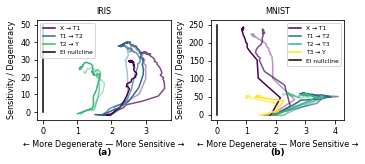

In [14]:
plt.figure(figsize=(5.5, 2.2))

ax = plt.subplot(1, 2, 1)
for i, run in enumerate(iris_runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(IRIS_LAYERS)):
        ei_layer = np.array([f[f"pairwise-ei:{l}-{l}"] for f in run])
        sensitivity_layer = np.array([f[f"pairwise-sensitivity:{l}-{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        xS = sensitivity_layer
        yS = degeneracy_layer
        xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        line, = ax.plot(xPrime, yPrime, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{iris_ltl[l]} → {iris_ltl[l+1]}")    
noEIChange, = ax.plot([0,0],[0, 50], c = 'black', label='EI nullcline')
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=8)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 8)
plt.title(f"IRIS", fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
ax.legend(prop={'size': 6})
ax.text(0.5, -0.35, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax = plt.subplot(1, 2, 2)
for i, run in enumerate(mnist_runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(MNIST_LAYERS)):
        ei_layer = np.array([f[f"pairwise-ei:{l}-{l}"] for f in run])
        sensitivity_layer = np.array([f[f"pairwise-sensitivity:{l}-{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        xS = sensitivity_layer
        yS = degeneracy_layer
        xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        line, = ax.plot(xPrime, yPrime, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{mnist_ltl[l]} → {mnist_ltl[l+1]}")    
noEIChange, = ax.plot([0,0],[0, 250], c = 'black', label='EI nullcline')
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=8)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 8)
plt.title(f"MNIST", fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
ax.legend(prop={'size': 6})
ax.text(0.5, -0.35, "(b)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)




plt.subplots_adjust(wspace=0.3, bottom=0.25)


plt.savefig('figures/iris-mnist-causal-plane.pdf', dpi=100)

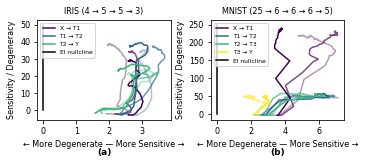

In [15]:
plt.figure(figsize=(5.5, 2.2))

ax = plt.subplot(1, 2, 1)
for i, run in enumerate(iris_runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(IRIS_LAYERS)):
        ei_layer = np.array([f[f"vector-ei:{l}-{l}"] for f in run])
        sensitivity_layer = np.array([f[f"pairwise-sensitivity:{l}-{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        xS = sensitivity_layer
        yS = degeneracy_layer
        xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        line, = ax.plot(xPrime, yPrime, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{iris_ltl[l]} → {iris_ltl[l+1]}")    
noEIChange, = ax.plot([0,0],[0, 50], c = 'black', label='EI nullcline')
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=8)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 8)
plt.title(f"IRIS (4 → 5 → 5 → 3)", fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
ax.legend(prop={'size': 6}, loc='upper left')
ax.text(0.5, -0.35, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax = plt.subplot(1, 2, 2)
for i, run in enumerate(mnist_runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(MNIST_LAYERS)):
        ei_layer = np.array([f[f"vector-ei:{l}-{l}"] for f in run])
        sensitivity_layer = np.array([f[f"pairwise-sensitivity:{l}-{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        xS = sensitivity_layer
        yS = degeneracy_layer
        xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        line, = ax.plot(xPrime, yPrime, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{mnist_ltl[l]} → {mnist_ltl[l+1]}")    
noEIChange, = ax.plot([0,0],[0, 250], c = 'black', label='EI nullcline')
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=8)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 8)
plt.title(f"MNIST (25 → 6 → 6 → 6 → 5)", fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
ax.legend(prop={'size': 6}, loc='upper left')
ax.text(0.5, -0.35, "(b)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


plt.subplots_adjust(wspace=0.3, bottom=0.25)


plt.savefig('figures/iris-mnist-causal-plane_whole_degeneracy.pdf', dpi=100)

# Load up shallow MNIST network

In [16]:
BINS = 8
SHALLOW_LAYERS = [(25, 6), (6, 5)]
ACTIVATION = nn.Sigmoid()
RUNS = 3
FREQUENCY = 10 # epochs per measurement
EPOCHS = 500
BATCH_SIZE = 50

top_str = ""
for i, l in enumerate(SHALLOW_LAYERS):
    if i == len(SHALLOW_LAYERS)-1:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-{out_w}"
    else:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-"

In [17]:
exp_dir = Path('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-5_8bins_fixedlonger/v2')
run_folders = [exp_dir / f"run{i}-frames" for i in range(1, RUNS+1)]
# run_folders = [here / "run1-frames"]
runs_frames = [list(run.glob('*.frame')) for run in run_folders]
print(run_folders)

[PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-5_8bins_fixedlonger/v2/run1-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-5_8bins_fixedlonger/v2/run2-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-5_8bins_fixedlonger/v2/run3-frames')]


In [18]:
all(d.exists() for d in run_folders)

True

In [19]:
def get_measures(path_to_frame):
    frame = torch.load(path_to_frame)
    measure_names = [
        'batches',
        'epochs',
        'training_loss',
        'testing_loss',
        'training_accuracy',
        'testing_accuracy',
        'model'
    ]
    for i in range(len(SHALLOW_LAYERS)):
        start_i = end_i = i
        measure_names.append(f"pairwise-ei:{start_i}-{end_i}")
        measure_names.append(f"pairwise-sensitivity:{start_i}-{end_i}")
        measure_names.append(f"vector-ei:{start_i}-{end_i}")
    measures = {}
    for name in measure_names:
        if type(frame[name]) is torch.Tensor:
            measures[name] = frame[name].item()
        else:
            measures[name] = frame[name]
    return measures

In [20]:
shallow_runs_datapoints = [[get_measures(path) for path in run_frames] for run_frames in runs_frames]
for shallow_run_datapoints in shallow_runs_datapoints:
    shallow_run_datapoints.sort(key=lambda f: f['batches'])

In [21]:
shallow_ltl = {
    0: 'X',
    1: 'T1',
    2: 'Y'
}

# load up deep MNIST

In [22]:
BINS = 8
DEEP_LAYERS = [(25, 6), (6, 6), (6, 6), (6, 6), (6, 6),  (6, 5)]
ACTIVATION = nn.Sigmoid()
RUNS = 3
FREQUENCY = 10 # epochs per measurement
EPOCHS = 500
BATCH_SIZE = 50

top_str = ""
for i, l in enumerate(DEEP_LAYERS):
    if i == len(DEEP_LAYERS)-1:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-{out_w}"
    else:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-"

In [23]:
exp_dir = Path('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-6-6-5_8bins_fixedlonger/v2/')
run_folders = [exp_dir / f"run{i}-frames" for i in range(1, RUNS+1)]
# run_folders = [here / "run1-frames"]
runs_frames = [list(run.glob('*.frame')) for run in run_folders]
print(run_folders)

[PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-6-6-5_8bins_fixedlonger/v2/run1-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-6-6-5_8bins_fixedlonger/v2/run2-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-6-6-5_8bins_fixedlonger/v2/run3-frames')]


In [24]:
all(d.exists() for d in run_folders)

True

In [25]:
def get_measures(path_to_frame):
    frame = torch.load(path_to_frame)
    measure_names = [
        'batches',
        'epochs',
        'training_loss',
        'testing_loss',
        'training_accuracy',
        'testing_accuracy',
        'model'
    ]
#     for (start_i, end_i) in combinations_with_replacement(range(len(DEEP_LAYERS)), 2):
    for i in range(len(DEEP_LAYERS)):
        start_i = end_i = i
        measure_names.append(f"pairwise-ei:{start_i}-{end_i}")
        measure_names.append(f"pairwise-sensitivity:{start_i}-{end_i}")
        measure_names.append(f"vector-ei:{start_i}-{end_i}")
    measures = {}
    for name in measure_names:
        if type(frame[name]) is torch.Tensor:
            measures[name] = frame[name].item()
        else:
            measures[name] = frame[name]
    return measures

In [26]:
deep_runs_datapoints = [[get_measures(path) for path in run_frames] for run_frames in runs_frames]
for deep_run_datapoints in deep_runs_datapoints:
    deep_run_datapoints.sort(key=lambda f: f['batches'])

In [27]:
deep_ltl = {
    0: 'X',
    1: 'T1',
    2: 'T2',
    3: 'T3',
    4: 'T4',
    5: 'T5',
    6: 'Y'
}

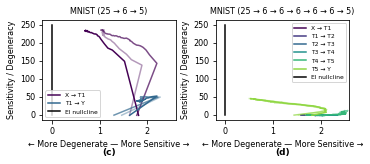

In [28]:
plt.figure(figsize=(5.5, 2.2))

ax = plt.subplot(1, 2, 1)
for i, run in enumerate(shallow_runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(SHALLOW_LAYERS)):
        ei_layer = np.array([f[f"pairwise-ei:{l}-{l}"] for f in run])
        sensitivity_layer = np.array([f[f"pairwise-sensitivity:{l}-{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        xS = sensitivity_layer
        yS = degeneracy_layer
        xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        line, = ax.plot(xPrime, yPrime, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{shallow_ltl[l]} → {shallow_ltl[l+1]}")    
noEIChange, = ax.plot([0,0],[0, 250], c = 'black', label='EI nullcline')
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=8)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 8)
ax.set_xlim(-0.2, 2.6)
plt.title(f"MNIST (25 → 6 → 5)", fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
ax.legend(loc='lower left', prop={'size': 6})
ax.text(0.5, -0.35, "(c)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax = plt.subplot(1, 2, 2)
for i, run in enumerate(deep_runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(DEEP_LAYERS)):
        ei_layer = np.array([f[f"pairwise-ei:{l}-{l}"] for f in run])
        sensitivity_layer = np.array([f[f"pairwise-sensitivity:{l}-{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        xS = sensitivity_layer
        yS = degeneracy_layer
        xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        line, = ax.plot(xPrime, yPrime, c=matplotlib.cm.viridis(l/6), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{deep_ltl[l]} → {deep_ltl[l+1]}")    
noEIChange, = ax.plot([0,0],[0, 250], c = 'black', label='EI nullcline')
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=8)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 8)
ax.set_xlim(-0.2, 2.6)
plt.title(f"MNIST (25 → 6 → 6 → 6 → 6 → 6 → 5)", fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
ax.legend(prop={'size': 6})
ax.text(0.5, -0.35, "(d)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)




plt.subplots_adjust(wspace=0.3, bottom=0.25)


plt.savefig('figures/shallow-deep-causal-plane.pdf', dpi=100)


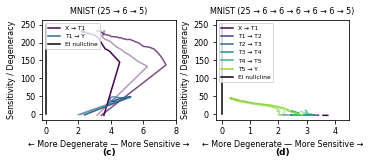

In [29]:
plt.figure(figsize=(5.5, 2.2))

ax = plt.subplot(1, 2, 1)
for i, run in enumerate(shallow_runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(SHALLOW_LAYERS)):
        ei_layer = np.array([f[f"vector-ei:{l}-{l}"] for f in run])
        sensitivity_layer = np.array([f[f"pairwise-sensitivity:{l}-{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        xS = sensitivity_layer
        yS = degeneracy_layer
        xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        line, = ax.plot(xPrime, yPrime, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{shallow_ltl[l]} → {shallow_ltl[l+1]}")    
noEIChange, = ax.plot([0,0],[0, 250], c = 'black', label='EI nullcline')
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=8)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 8)
ax.set_xlim(-0.2, 8.0)
plt.title(f"MNIST (25 → 6 → 5)", fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
ax.legend(loc='upper left', prop={'size': 6})
ax.text(0.5, -0.35, "(c)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax = plt.subplot(1, 2, 2)
for i, run in enumerate(deep_runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(DEEP_LAYERS)):
        ei_layer = np.array([f[f"vector-ei:{l}-{l}"] for f in run])
        sensitivity_layer = np.array([f[f"pairwise-sensitivity:{l}-{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        xS = sensitivity_layer
        yS = degeneracy_layer
        xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        line, = ax.plot(xPrime, yPrime, c=matplotlib.cm.viridis(l/6), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{deep_ltl[l]} → {deep_ltl[l+1]}")    
noEIChange, = ax.plot([0,0],[0, 250], c = 'black', label='EI nullcline')
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=8)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 8)
ax.set_xlim(-0.2, 4.5)
plt.title(f"MNIST (25 → 6 → 6 → 6 → 6 → 6 → 5)", fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
ax.legend(prop={'size': 6}, loc='upper left')
ax.text(0.5, -0.35, "(d)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)




plt.subplots_adjust(wspace=0.3, bottom=0.25)


plt.savefig('figures/shallow-deep-causal-plane_whole_degeneracy.pdf', dpi=100)
